<a href="https://colab.research.google.com/github/vortexash/Tensorflow-Developer/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about new kind of transfer learning: fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Tue Nov 30 16:40:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've create a bunch of helper functions, now we could rewrite them all,however,this is tedious.

So, it's a good idea to put functions we'll want to use again in ascript we can download and import into our notebooks(or elsewhere).

We've done this for some of the functions we've using previously https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-30 16:40:10--  https://raw.githubusercontent.com/vortexash/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-30 16:40:10 (75.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If we're running this notebook in google colab, when it times out colab will delete `helper_functions.py`, so you'll have to re-download it if we want to access ti our helper functions.

## Let's get some data

This time we're are going to see how we can use the pre-trained models within tf.keras.applications and apply then to our own problem (recognizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

--2021-11-30 16:40:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   181MB/s    in 0.9s    

2021-11-30 16:40:14 (181 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and sub-directories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10

In [6]:
# Create and training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = 'categorical',
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                               image_size = IMG_SIZE,
                                                               label_mode = 'categorical',
                                                               batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
# Check out the class names of the dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# Seeing an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)


tf.Tensor(
[[[[2.01928574e+02 1.69928574e+02 1.18928574e+02]
   [2.14454071e+02 1.82454071e+02 1.33454071e+02]
   [1.97903061e+02 1.66903061e+02 1.20117348e+02]
   ...
   [3.36717868e+00 5.36717844e+00 1.37741089e+00]
   [1.14797182e+01 1.64797192e+01 1.04797182e+01]
   [2.50867577e+01 3.00867577e+01 2.40867577e+01]]

  [[2.05785721e+02 1.74857147e+02 1.27642860e+02]
   [2.19790817e+02 1.88790817e+02 1.42653061e+02]
   [2.16255096e+02 1.85255096e+02 1.39255096e+02]
   ...
   [2.44872928e-01 1.45913684e+00 0.00000000e+00]
   [3.06151718e-01 4.44391870e+00 1.68384731e-01]
   [4.85717583e+00 9.85717583e+00 3.85717583e+00]]

  [[2.15158157e+02 1.88801010e+02 1.44015305e+02]
   [2.29928574e+02 2.01357147e+02 1.57571426e+02]
   [2.19668365e+02 1.90193878e+02 1.46668365e+02]
   ...
   [2.45408726e+00 4.68881512e+00 5.96943855e-01]
   [1.69897783e+00 4.69897795e+00 8.41834486e-01]
   [9.94891107e-01 4.42346287e+00 5.66319406e-01]]

  ...

  [[1.23173470e+02 1.27744934e+02 9.59592056e+01]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it euns layers in sequential order.

But the functional API gives more flexibility with our models.
https://www.tensorflow.org/guide/keras/functional

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained  aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using model like ResNet50v2 we will need to normalize inputs(you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# 5. Pass the input to the base_model
x = base_model(inputs)
print(f" Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "gobal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape} ")

# 7. Create the output  activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])
# 10. Fit our model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                  epochs=5, 
                                  steps_per_epoch =len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps= int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
 Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280) 
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211130-164024


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 24s 343ms/step - loss: 2.0029 - accuracy: 0.3200 - val_loss: 1.4271 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - 7s 258ms/step - loss: 1.2141 - accuracy: 0.7133 - val_loss: 0.9689 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - 7s 258ms/step - loss: 0.8773 - accuracy: 0.7973 - val_loss: 0.8095 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - 7s 257ms/step - loss: 0.7162 - accuracy: 0.8333 - val_loss: 0.7229 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 9s 356ms/step - loss: 0.6137 - accuracy: 0.8573 - val_loss: 0.6265 - val_accuracy: 0.8355


In [12]:
# Evaluate on the ful test data
model_0.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.6176 - accuracy: 0.8352


[0.6176035404205322, 0.8352000117301941]

In [13]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# How about we get summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gobal_average_pooling_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


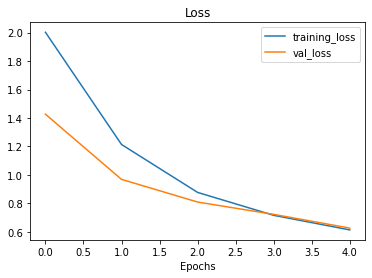

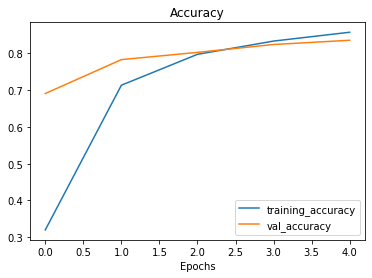

In [16]:
# Check out our model's training curve
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model 

Let's demonstrate the Gobal Average Pooling 2D layer..

WE have a tensor after our model goes through `base_model` of shape (None, 7,7,1280).

But then whet it passes  through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GobalAveragePooling2D.

In [17]:
# Define the input shape
input_shape =(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor =tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tenosr through a gobal average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D  global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the differerent tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D  global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
shape of Global Average Pooled 2D tensor:(1, 3)


In [18]:
# Let's replicate the GobalAveragePoole2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to do the same with the above two cells but this time use `GobalMaxPool2D`..and see what happens.

**Note:** One of the reasins feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layer.GobalAveragePooled2D()` layer) which can then be used to extract patterns out of for own specific problem.

## Running a series of transfer learning experiments

We've have seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.

2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.

4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model.. this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data - preprocess fro Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-11-30 16:41:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   156MB/s    in 0.8s    

2021-11-30 16:41:32 (156 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Creatinf training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size= BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size= BATCH_SIZE) # default = 32

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use layers inside:

* `tf.keras.layers.experimental.preprocessing()`

we can see the benifits of doing this within the Tensorfow Data augmentation documentation:https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmentating them)happens on the GPU (much faster) rrather the CPU

* Image data augmentation only happens during training, so we can still export our modle and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing. RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

### Visualise our data augmentation layer (and see what happens to our data)

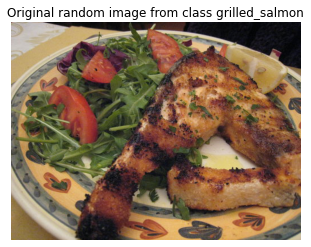

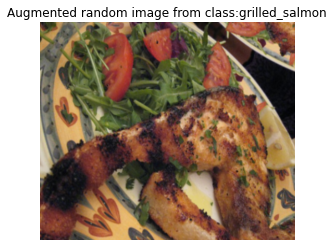

In [24]:
# View a random image and comapre it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class:{target_class}")
plt.axis(False);

In [25]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 1: Feautre extraction Transfer Learning on 1% of the data with data augmentation

In [26]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_mosel the inputs (after augmentation) and don't train it

x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a Ddense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a model using the inputs and outputs
model_1 =  keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211130-164137
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 16s 4s/step - loss: 2.4627 - accuracy: 0.0857 - val_loss: 2.2379 - val_accuracy: 0.1793
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1896 - accuracy: 0.2000 - val_loss: 2.1090 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9862 - accuracy: 0.3714 - val_loss: 2.0170 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8184 - accuracy: 0.5000 - val_loss: 1.9095 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6613 - accuracy: 0.5857 - val_loss: 1.8381 - val_accuracy: 0.4178


In [27]:
# Check out outr modle summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [28]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 129ms/step - loss: 1.8209 - accuracy: 0.4376


[1.8209261894226074, 0.4375999867916107]

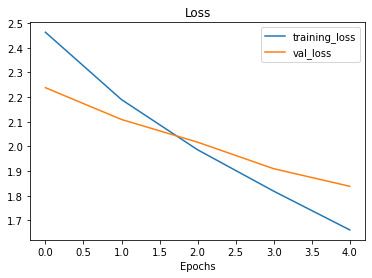

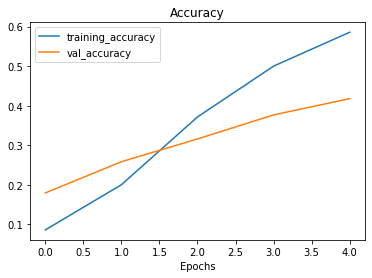

In [29]:
# How do the model with 1% of the and data augmentation loss curves look? 
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learing with 10% of data and data augmentation

In [30]:
# Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [31]:
#  How many images are in our directories?
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.


In [32]:
# Set data inputs
import tensorflow as tf
IMG_SIZE =(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescale(1./255), If your are using model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built in.
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224,224, 3)

# Create a frozen model(also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment out training images (augmentation doesn't occure on test data)
x = base_model(x, training=False) # We pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Create a ModelCheckpoint Callback

The modelCheckpoint callback intermediately saves out model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [35]:
 # Set checkpoint path

 checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

 # Create a ModelCheckpoint callback that saves the model's weight only
 checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    save_weights_only=True,
                                                                    save_best_only=False,
                                                                    save_freq="epoch", #save every epoch
                                                                    verbose=1)

##Fit model 2 passing in the ModelCheckpoint callback

In [36]:
# fit the model 2 passing in the ModelCheckpoint callback
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211130-164231
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 2.0133 - accuracy: 0.3427
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 838ms/step - loss: 2.0133 - accuracy: 0.3427 - val_loss: 1.4810 - val_accuracy: 0.6727
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3514 - accuracy: 0.6933
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 595ms/step - loss: 1.3514 - accuracy: 0.6933 - val_loss: 1.0489 - val_accuracy: 0.7632
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.7627
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 539ms/step - loss: 1.0481 - accuracy: 0.7627 - val_loss: 0.8445 - val_accuracy: 0.8076
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 

In [37]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.6176 - accuracy: 0.8352


[0.6176037788391113, 0.8352000117301941]

In [38]:
# Check model_2 results on all test_data
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 11s 128ms/step - loss: 0.7009 - accuracy: 0.8064


[0.7008861303329468, 0.8064000010490417]

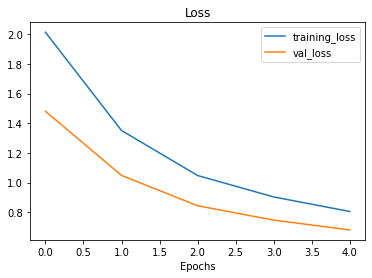

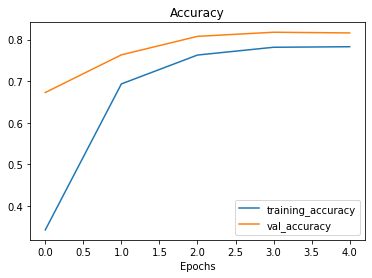

In [39]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [40]:
# Loading save model weight and evaluate model

model_2.load_weights(checkpoint_path)

In [41]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.7009 - accuracy: 0.8064


In [42]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
result_10_percent_data_aug == loaded_weights_model_results

True

In [43]:
result_10_percent_data_aug

[0.7008861303329468, 0.8064000010490417]

In [44]:
loaded_weights_model_results

[0.7008861303329468, 0.8064000010490417]

np.isclose: https://numpy.org/doc/stable/reference/generated/numpy.isclose.html

In [45]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(result_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [46]:
# Check the difference between the two results
print(np.array(result_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model: Fine-tuning on existing model on 10 percent of data

**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [47]:
 # Layers in loaded model
 model_2.layers

In [48]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0665ebd350> True
<keras.engine.sequential.Sequential object at 0x7f0665ec5e50> True
<keras.engine.functional.Functional object at 0x7f0665a06290> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0665eac750> True
<keras.layers.core.dense.Dense object at 0x7f0665951950> True


In [49]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [50]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [51]:
# To begin fine tuning lerts start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # When fine-tuning you typically want to  lower the learning rate by 10X*
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10X (though different sources will calim other values).
A good resource for information on this is the UMFIT paper:https://arxiv.org/abs/1801.06146

In [52]:
# Check which layer are trainable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [53]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable are present
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name= "transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211130-164434


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 25s 669ms/step - loss: 0.6945 - accuracy: 0.8080 - val_loss: 0.5108 - val_accuracy: 0.8520
Epoch 6/10
24/24 [==============================] - 15s 620ms/step - loss: 0.5568 - accuracy: 0.8360 - val_loss: 0.4998 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 15s 630ms/step - loss: 0.4757 - accuracy: 0.8453 - val_loss: 0.4904 - val_accuracy: 0.8487
Epoch 8/10
24/24 [==============================] - 12s 511ms/step - loss: 0.4494 - accuracy: 0.8547 - val_loss: 0.4654 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 15s 593ms/step - loss: 0.4187 - accuracy: 0.8720 - val_loss: 0.4637 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 12s 476ms/step - loss: 0.3631 - accuracy: 0.8987 - val_loss: 0.4358 - val_accuracy: 0.8618


In [55]:
# Evaluate the fine tuned model(model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.4873 - accuracy: 0.8320


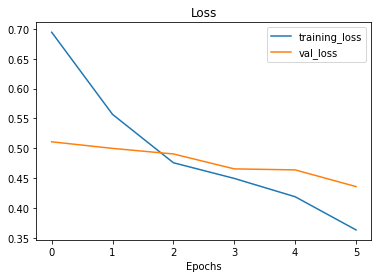

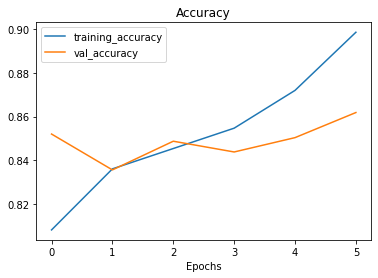

In [56]:
# Check out the lost curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curve` function works great with models which have onlty been fit once, however, we want something to compare one series of running `fit()` with another (e.g before and after fine_tuning).


In [57]:
# Let create a function to caompare training histories
def compare_historys(original_history, new_history , initial_epochs=5):
  """
  comapares two TensorFlow History objects.
  """
  # Get original history mesurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc , label="val Accuracy")

  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label= "Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

   # make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss , label="val Loss")

  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(),label= "Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation LOss")

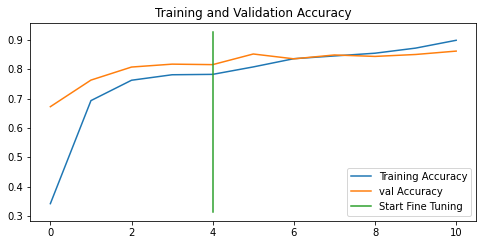

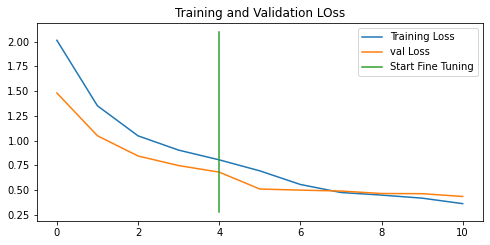

In [58]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug , initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [60]:
# Dpwnload and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-11-30 16:55:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   189MB/s    in 2.6s    

2021-11-30 16:55:39 (189 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [61]:
# Set up training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [62]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [66]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data wer loaded in same what we have been using for previous experiments (all experiments have used the same test dataset).

Let's verify this..

In [67]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.4873 - accuracy: 0.8320


[0.48729678988456726, 0.8320000171661377]

In [68]:
results_fine_tune_10_percent

[0.4872966408729553, 0.8320000171661377]

To train a fine-tuning (model_4) we need to revert back to its feature extraction weights.

In [71]:
# Load weights from checkpoint, that way we can fine-tune from 
#the same stage the 10 oercent data model was fine-tuned from
model_2.load_weights(checkpoint_path) 

In [72]:
# Let's evaluiate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 11s 129ms/step - loss: 0.7009 - accuracy: 0.8064


[0.7008861899375916, 0.8064000010490417]

In [74]:
# Check to see if our model_2 has been reverted back to feature extraction results
result_10_percent_data_aug

[0.7008861303329468, 0.8064000010490417]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using  `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step2 except this time we're going to use all of the data(model4).

In [75]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [77]:
# Let's drill ibnto our base_model (efficientnetb0) and see what layer are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [78]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [86]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                         epochs= fine_tune_epochs,
                                         validation_data= test_data,
                                         validation_steps = int(0.25 * len(test_data)),
                                         initial_epoch=history_10_percent_data_aug.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                          experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211130-173733
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 91s 351ms/step - loss: 0.7328 - accuracy: 0.7635 - val_loss: 0.4004 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 71s 301ms/step - loss: 0.5975 - accuracy: 0.8083 - val_loss: 0.3495 - val_accuracy: 0.9095
Epoch 7/10
235/235 [==============================] - 69s 292ms/step - loss: 0.5339 - accuracy: 0.8292 - val_loss: 0.3501 - val_accuracy: 0.8947
Epoch 8/10
235/235 [==============================] - 65s 275ms/step - loss: 0.4878 - accuracy: 0.8436 - val_loss: 0.3479 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 60s 253ms/step - loss: 0.4515 - accuracy: 0.8533 - val_loss: 0.3272 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 62s 260ms/step - loss: 0.4259 - accuracy: 0.8647 - val_loss: 0.3229 - val_accuracy: 0.9161


In [91]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data 

79/79 [==============================] - 11s 128ms/step - loss: 0.3003 - accuracy: 0.9016


[0.3002961277961731, 0.9016000032424927]

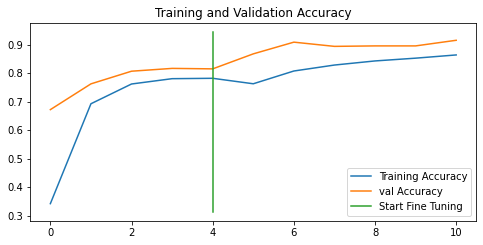

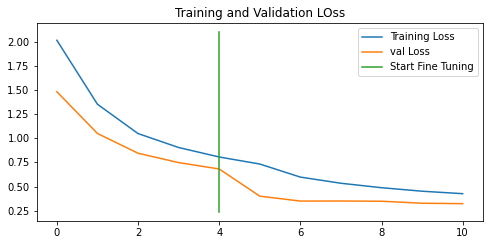

In [93]:
# How did fine_tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 **Note:** Anything we upload to TensorBoard.dev is going to be public. So if we have private data, do not upload.


In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiment with 10 Food101 Classes"\
 --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning."\
 --one_shot # exists the uploader onceits finished uploading

My Tensorboard experiments are available at: https://tensorboard.dev/experiment/bjqc5t4NRlmR5REJWGu9oQ/

In [96]:
# View all of the uploaded TensorBoard.dev experiments (public)
#!tensorboard dev list

https://tensorboard.dev/experiment/bjqc5t4NRlmR5REJWGu9oQ/
	Name                 Transfer Learning Experiment with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   bjqc5t4NRlmR5REJWGu9oQ
	Created              2021-11-30 18:00:19 (7 minutes ago)
	Updated              2021-11-30 18:00:29 (6 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4151022
https://tensorboard.dev/experiment/QsAdB4ahRu62VK4FqSV16g/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   QsAdB4ahRu62VK4FqSV16g
	Created              2021-10-03 15:46:35
	Updated              2021-10-03 15:46:37
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes        

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id bjqc5t4NRlmR5REJWGu9oQ